In [27]:
import numpy as np
import quaternion as qt
import library.ulogReader as ur
import library.quaternionUtils as qu
import library.choleskyDecomposition as cd
import library.quaternionVisualisation as qv

from pyulog import ULog

## Wczytanie danych lotu drona

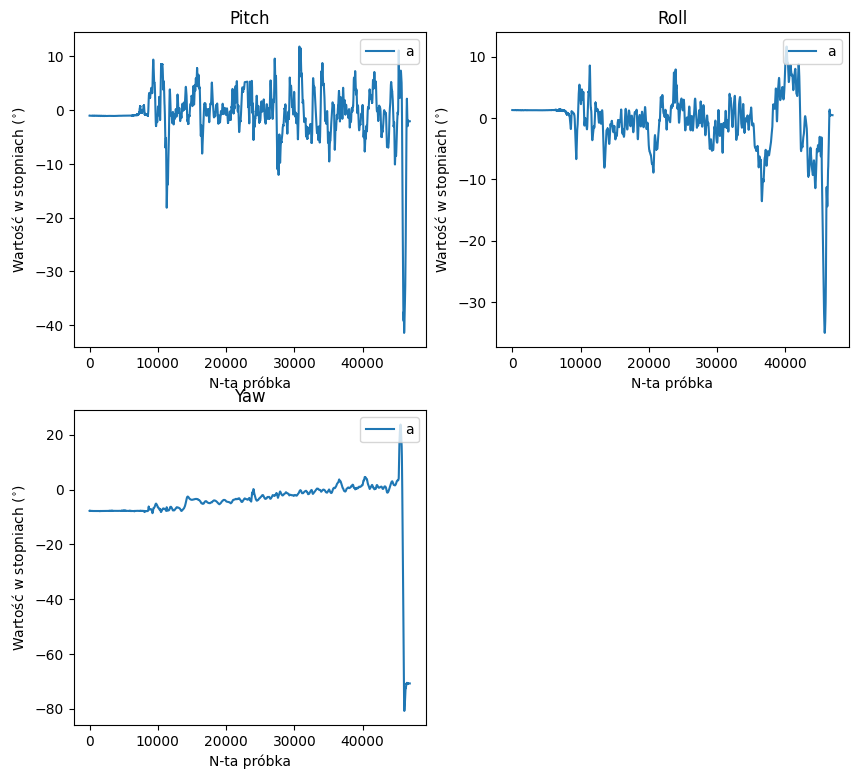

In [28]:
ulog_path = './ulogs/639_bs10_out_alt.ulg'
ulog = ULog(ulog_path)

attitude, attitude_time  = ur.readAttitude(ulog)
attitude_time = (attitude_time - attitude_time[0]) / 1e3

qv.display_quat_as_euler([attitude], [attitude_time], ['a'])


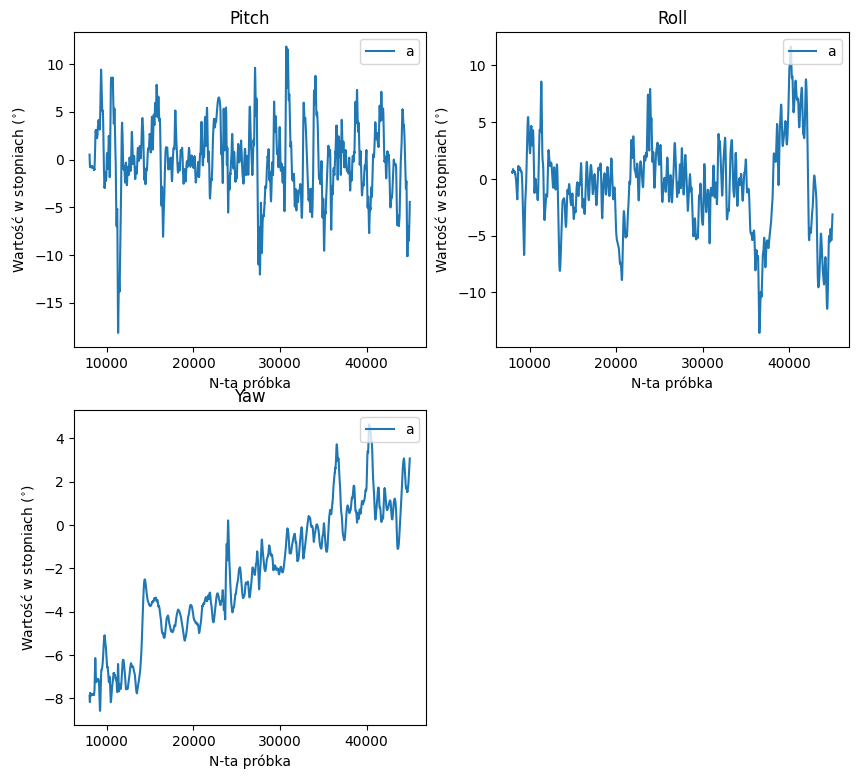

In [29]:
start_time = 8e3   
end_time   = 45e3

# Config interpolation
dt = 2      # Delta time in ms
degree = 3  # Spline degree

# Post resampling time
it_t = np.arange(start_time, end_time, dt)
attitude = qu.splineInterpolation(attitude, attitude_time, it_t, degree)
attitude_time = it_t

qv.display_quat_as_euler([attitude], [attitude_time], ['a'])

## Modele predykcyjne
---

In [30]:
P_ORDER = 5
K_FORECAST = [10]

### Metoda Yule-Walkera

In [31]:
N_WINDOW = 8            # Minimal value (N_WINDOW > P_ORDER + 1)
START_WINDOW = 30
MU = 5e-3

x = np.copy(attitude)[::2]
y_yule = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

corr_matrix = qu.correlationMatrix(x[:START_WINDOW][::-1], P_ORDER + 1 , normalize=True)

for i in range(START_WINDOW, x.shape[0]+1):
    tmp_corr_matrix = qu.correlationMatrix(x[i-N_WINDOW : i][::-1], P_ORDER + 1, normalize=True)
    corr_matrix = (1-MU) * corr_matrix + MU * tmp_corr_matrix
    tmp_corr_matrix = np.copy(corr_matrix)
    np.fill_diagonal(tmp_corr_matrix, tmp_corr_matrix.diagonal()+qt.quaternion(1e-6,0,0,0))
    l = cd.choleskyDecomposition(tmp_corr_matrix[:-1, :-1])
    w = cd.solveLLHEquation(l, tmp_corr_matrix[1:,0])

    for k, k_steps in enumerate(K_FORECAST):
        y_yule[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER-1 : i][::-1]), np.concatenate(([qt.quaternion(1,0,0,0)],w)), k_steps)

### Metoda QLMS 

In [32]:
MU = 1e-3

x = np.copy(attitude)[::2]
y_qlms = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

w = qu.randQuaternionVector(P_ORDER)

for i in range(P_ORDER, x.shape[0]):
    s = x[i-P_ORDER : i][::-1]

    for k, k_steps in enumerate(K_FORECAST):
        y_qlms[k, i + k_steps - 1] = qu.predictionKSteps(s.copy(), w, k_steps)
    
    e_priori = x[i] - np.sum(w * s)
    w = w + MU * (2 * e_priori * s.conjugate() -      # Update coefficients
                  s.conjugate() * e_priori.conjugate() )

### Metoda RLS

In [33]:
MU  = 1e-5
LMB = 0.85 

x = np.copy(attitude)[::2]
y_rls = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

w = qu.randQuaternionVector(P_ORDER)

r = np.zeros((P_ORDER, P_ORDER), dtype=qt.quaternion)
g = np.zeros((P_ORDER, 1), dtype=qt.quaternion)
v = np.zeros((P_ORDER, 1), dtype=qt.quaternion)

for i in range(P_ORDER, x.shape[0]):
    s = x[i-P_ORDER : i][::-1].reshape(P_ORDER,1)

    for k, k_steps in enumerate(K_FORECAST):
        y_rls[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER : i][::-1]), w, k_steps)

    e_priori = x[i] - np.sum(w * s)
    r = LMB * r + qu.quaternionMatrixMultiply(s, s.T.conjugate())
    g = LMB * g - s * e_priori
    v = qu.quaternionMatrixMultiply(r,g)
    alp = MU * np.sqrt(np.sum(qt.as_float_array(g)**2))
    w = w - g * alp
    g = g - v * alp

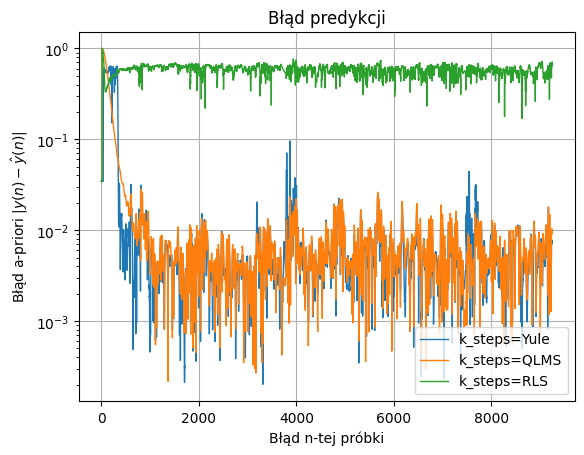

In [34]:
qv.displayPredictionError(x,
                          np.array([y_yule[0], y_qlms[0], y_rls[0]]),
                          ['Yule', 'QLMS', 'RLS'],
                          label_form='Metoda {}')